# Transfer Learning with TensorFlow Part 2: Fine-tuning

In previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of a Transfer Learning : Fine-tuning

In [ ]:
!nvidia-smi

Fri Oct 15 22:40:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating Helper functions

In previous notebooks, we have covered a bunch of helper functions, now we could rewrite them all, however this is tidious.

So it's a good idea to put functions you will want to use again in a script you can download and import into your notebooks.

We have done this for some of our functions we have used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-15 22:40:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-15 22:40:52 (69.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we are going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

**Note:** If you are running this notebook in Google colab, when it times out colab will delete all the donwloaded fies.



## Let's get some data

This time we are going to se how we can use the pretrained models within `tf.kreas.applications` and apply them to our own problem (recognizing images of foods.)

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2021-10-15 22:40:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 66.102.1.128, 142.251.5.128, 74.125.206.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|66.102.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  52.1MB/s    in 3.1s    

2021-10-15 22:40:59 (52.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/trai

In [ ]:
# Create training and test directories paths
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'


In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of batches of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[3.16887760e+01 7.68877554e+00 6.40306091e+00]
   [2.86122456e+01 7.47448969e+00 3.23469329e+00]
   [3.21836739e+01 1.11836739e+01 6.74489784e+00]
   ...
   [8.79590321e+00 5.79590273e+00 7.95902848e-01]
   [7.00000000e+00 6.00000000e+00 2.00000000e+00]
   [5.51525879e+00 4.51525879e+00 6.42822266e-01]]

  [[3.06632652e+01 6.59183598e+00 3.31631392e-01]
   [3.13622437e+01 7.42346764e+00 5.66324413e-01]
   [3.15510197e+01 9.47959328e+00 1.98979780e-01]
   ...
   [8.80104065e+00 5.80104065e+00 8.01040590e-01]
   [5.00508976e+00 4.00508976e+00 7.14282990e-02]
   [6.35717773e+00 5.35717773e+00 1.35717773e+00]]

  [[3.04948978e+01 9.56632805e+00 7.65306503e-02]
   [3.62449036e+01 1.76734753e+01 4.25510550e+00]
   [5.20561295e+01 3.41734810e+01 1.87908287e+01]
   ...
   [9.04593563e+00 5.42857170e+00 1.57147217e+00]
   [5.64285755e+00 4.64285755e+00 4.28571701e-01]
   [6.13774776e+00 5.13774776e+00 9.23461854e-01]]

  ...

  [[2.41183746e+02 2.35540955e+02 1.97892960e+02]
   [2

## Model 0: Building a transfer learning model using the Kreas Functional API

The Sequential API is straight-forwardd

In [ ]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pretrained patterns aren't updated for training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape}')

# 6. Average pool the outputs of the base model (aggregate all the most important )
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the mode
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model and save it's history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name='fine-tuning',
                                                                        experiment_name='10_percent_feature_extraction')])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: fine-tuning/10_percent_feature_extraction/20211015-224112
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 46s 467ms/step - loss: 2.0032 - accuracy: 0.3267 - val_loss: 1.4143 - val_accuracy: 0.6875
Epoch 2/5
24/24 [==============================] - 7s 270ms/step - loss: 1.1872 - accuracy: 0.7360 - val_loss: 0.9271 - val_accuracy: 0.8026
Epoch 3/5
24/24 [==============================] - 7s 263ms/step - loss: 0.8623 - accuracy: 0.8040 - val_loss: 0.7504 - val_accuracy: 0.8273
Epoch 4/5
24/24 [==============================] - 9s 358ms/step - loss: 0.7025 - accuracy: 0.8400 - val_loss: 0.6385 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 7s 266ms/step - loss: 0.6116 - accuracy: 0.8600 - val_loss: 0.5696 - val_accuracy: 0.8470


In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 11s 136ms/step - loss: 0.6137 - accuracy: 0.8384


[0.6136655807495117, 0.8384000062942505]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
# How about we get a summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [ ]:
# How about a summaryof our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


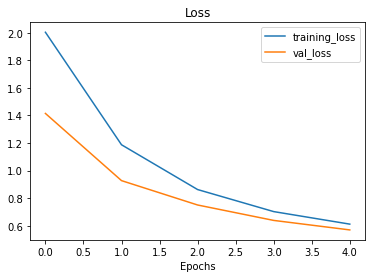

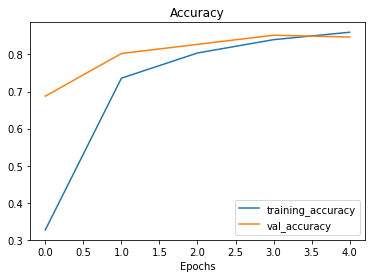

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (NOne, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280)

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3) 

# Create a rondom tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(input_tensor)

# Pass the random tensor through a glbal average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor: \n {global_average_pooled_tensor}')

# Check the shape of the different tensors
print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Shape of Global Average pooled 2D tensor: {global_average_pooled_tensor.shape}')

tf.Tensor(
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]], shape=(1, 4, 4, 3), dtype=float32)
2D global average pooled random tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]]
Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average pooled 2D tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`... and see what happens.

# Running a series of Teansfer Learning experiments

We have seen the incredible results transfer learning can get with only 10 % of the training data, but how does it go with 1% of training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 1-% of the training data with data augmentation.
3. `model_3` - 

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

--2021-10-15 22:42:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 66.102.1.128, 142.250.110.128, 142.251.5.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|66.102.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  61.2MB/s    in 2.1s    

2021-10-15 22:42:58 (61.2 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [ ]:
# How many images we are working with
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There a

In [ ]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                      label_mode='categorical',
                                                                      image_size=IMG_SIZE,
                                                                      batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.experimental.preprocessing()`

We can see the benifits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/image/data_augmentation

Off the top our heads, after reading the docs, the benefits of using data augmetation inside the model are:

* Preprocessing of image (augmenting them) happnes on the GPU (much faster) rather than CPU.

* Image data augmentation.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmetation stage with horizontal flipping, roatation, zooms, etc
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),                                      
], name='data_augmentation')



(-0.5, 572.5, 511.5, -0.5)

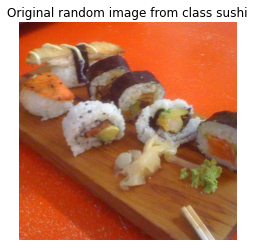

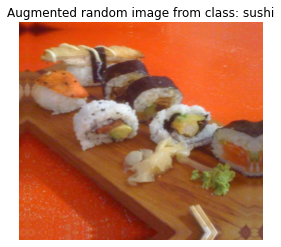

In [ ]:
# View a random image and compare it to it's augmentaed version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'Original random image from class {target_class}')
plt.axis(False)

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f'Augmented random image from class: {target_class}')
plt.axis(False)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layer
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# Add in data augmentation sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation='softmax', name = 'output_layer')(x)

# Make a model using the input and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                        experiment_name='1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20211015-224304
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 32s 12s/step - loss: 2.3721 - accuracy: 0.1143 - val_loss: 2.2219 - val_accuracy: 0.1824
Epoch 2/5
3/3 [==============================] - 12s 6s/step - loss: 2.1191 - accuracy: 0.3000 - val_loss: 2.0998 - val_accuracy: 0.2696
Epoch 3/5
3/3 [==============================] - 12s 5s/step - loss: 1.9728 - accuracy: 0.4143 - val_loss: 1.9926 - val_accuracy: 0.3332
Epoch 4/5
3/3 [==============================] - 12s 6s/step - loss: 1.8125 - accuracy: 0.4571 - val_loss: 1.9011 - val_accuracy: 0.3924
Epoch 5/5
3/3 [==============================] - 12s 6s/step - loss: 1.6725 - accuracy: 0.6143 - val_loss: 1.8177 - val_accuracy: 0.4380


In [ ]:
# Check out the model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Evaluate on the full test_data set
results_1_percent_data_aug = model_1.evaluate(test_data)

79/79 [==============================] - 11s 130ms/step - loss: 1.8177 - accuracy: 0.4380


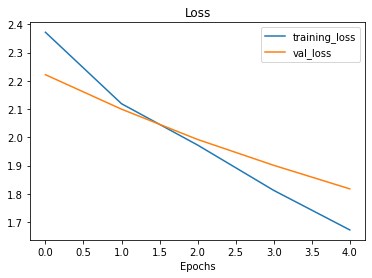

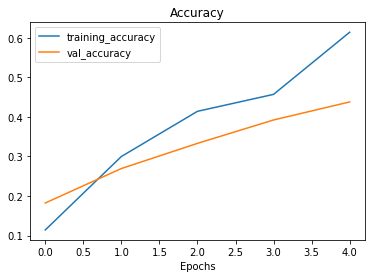

In [ ]:
# How do the model with 1% of data and data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning with 10% of the full data with data augmentation

In [ ]:
# Get 10% of the data
# unzip _data(10_food_classes_10_percent)

train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

IMG_SHAPE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SHAPE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SHAPE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create model_2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./225) # If you are using a model such as ResNet50V2, you will need to rescale your data, efficientnet has rescaling built-in

], name='data_augmentation')

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including teh layers in between)
inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False) # Pass the augmented images to the base model but keep it in inference mode, this also insures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name='global_average_pooling_2D')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs)

# compile the mode
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_2D (G (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path = 'ten_percent_model_checkpoint_weights/checkpoints.ckpt'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch',
                                                         verbose=1)

### Fit model_2 passing in the model checkpoint callback

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name='transfer_learning',

                                                                                 experiment_name='10_percent_data_aug'), checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20211015-231540
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 25s 750ms/step - loss: 1.9970 - accuracy: 0.3280 - val_loss: 1.4841 - val_accuracy: 0.6234

Epoch 00001: saving model to ten_percent_model_checkpoint_weights/checkpoints.ckpt
Epoch 2/5
24/24 [==============================] - 15s 611ms/step - loss: 1.3745 - accuracy: 0.6573 - val_loss: 1.0468 - val_accuracy: 0.7664

Epoch 00002: saving model to ten_percent_model_checkpoint_weights/checkpoints.ckpt
Epoch 3/5
24/24 [==============================] - 17s 690ms/step - loss: 1.0850 - accuracy: 0.7173 - val_loss: 0.8654 - val_accuracy: 0.7829

Epoch 00003: saving model to ten_percent_model_checkpoint_weights/checkpoints.ckpt
Epoch 4/5
24/24 [==============================] - 14s 563ms/step - loss: 0.9241 - accuracy: 0.7627 - val_loss: 0.7508 - val_accuracy: 0.8076

Epoch 00004: saving model to ten_percent_model_checkpoint_weights/checkpoints.ckpt
Epoch 5/5
24/24 [==============================] - 13s 526ms/step - loss: 0.8172 - accuracy: 0.7787 - val_

In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 11s 131ms/step - loss: 0.6137 - accuracy: 0.8384


[0.6136656999588013, 0.8384000062942505]

In [ ]:
# Check model_2 results on all test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 11s 133ms/step - loss: 0.6985 - accuracy: 0.8128


[0.6985285878181458, 0.8127999901771545]

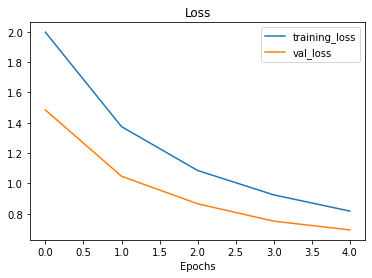

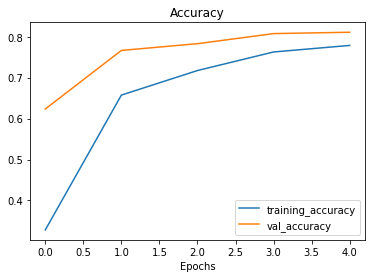

In [ ]:
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate mdoel_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 11s 132ms/step - loss: 0.6985 - accuracy: 0.8128


In [ ]:
# If the results from our previously evaluate model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug

[0.6985285878181458, 0.8127999901771545]

In [ ]:
loaded_weights_model_results

[0.6985287070274353, 0.8127999901771545]

In [ ]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-1.1920929e-07  0.0000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

>**Note:** Fine-tuning usually work best **after&& training a feature extraction model for a few epochs with large amounts of custom data.


In [ ]:
# Layers in our loaded model
model_2.layers

In [ ]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fc816cda6d0> True
<keras.engine.sequential.Sequential object at 0x7fc816d68c50> True
<keras.engine.functional.Functional object at 0x7fc815f92990> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fc816a3b9d0> True
<keras.layers.core.Dense object at 0x7fc816a32690> True


In [ ]:
# What layers are in our base model and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7fc816d68ad0> False
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fc816d68d50> False
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7fc816c967d0> False
3 <keras.layers.convolutional.ZeroPadding2D object at 0x7fc816c9bf10> False
4 <keras.layers.convolutional.Conv2D object at 0x7fc816c90810> False
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc816c9b090> False
6 <keras.layers.core.Activation object at 0x7fc816cf5a50> False
7 <keras.layers.convolutional.DepthwiseConv2D object at 0x7fc816d26150> False
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fc816d1a650> False
9 <keras.layers.core.Activation object at 0x7fc816c96b50> False
10 <keras.layers.pooling.GlobalAveragePooling2D object at 0x7fc816d2db10> False
11 <keras.layers.core.Reshape object at 0x7fc816de7190> False
12 <keras.layers.convolutional.Conv2D object at 0x7f

In [ ]:
# How many trainable varibales are in our base model
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine-tuning let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we maek a change)
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=0.001), # when fine-tuning you typically want to lower the learning ratre by 10x* 
                metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Now we have unfrozen some of the layers closer to the top, how many trainable variables are there
print(len(model_2.trainable_variables))

12


In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch)
                                               callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                      experiment_name='10_percent_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20211016-000548
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 28s 824ms/step - loss: 0.7778 - accuracy: 0.7480 - val_loss: 0.6090 - val_accuracy: 0.8191
Epoch 6/10
24/24 [==============================] - 12s 499ms/step - loss: 0.4045 - accuracy: 0.8760 - val_loss: 0.6383 - val_accuracy: 0.8076
Epoch 7/10
24/24 [==============================] - 12s 503ms/step - loss: 0.2916 - accuracy: 0.9107 - val_loss: 0.6273 - val_accuracy: 0.8043
Epoch 8/10
24/24 [==============================] - 14s 575ms/step - loss: 0.2098 - accuracy: 0.9373 - val_loss: 0.5757 - val_accuracy: 0.8224
Epoch 9/10
24/24 [==============================] - 14s 579ms/step - loss: 0.1457 - accuracy: 0.9520 - val_loss: 0.6025 - val_accuracy: 0.8273
Epoch 10/10
24/24 [==============================] - 13s 506ms/step - loss: 0.1170 - accuracy: 0.9747 - val_loss: 0.6421 - val_accuracy: 0.8421


In [ ]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 11s 132ms/step - loss: 0.5444 - accuracy: 0.8416


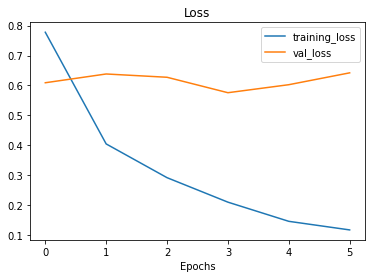

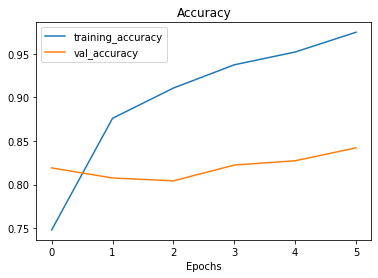

In [ ]:
# Check out the loss curves 
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss curves` funciton works great with models which have only been fit once, however , we want

In [ ]:
# Let's create a function 
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """

  # Get original history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine original history metrics with new_history metrics
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make plot for accuacy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Val Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  # Make plot for loss

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Val Loss')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')


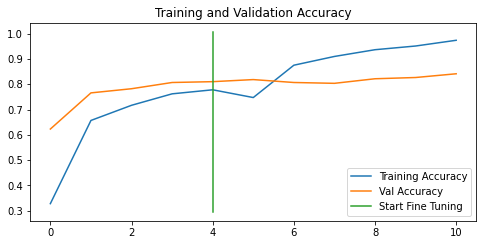

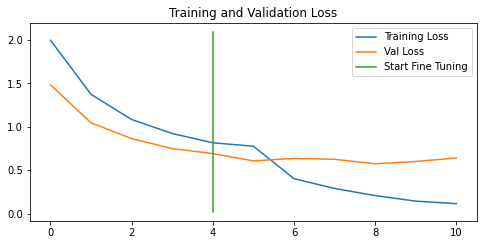

In [ ]:
compare_histories(history_10_percent_data_aug,
                  history_fine_10_percent_data_aug,
                  initial_epochs=5)

# Model 4: Fine-tuning and existing model on all of the data


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data('10_food_classes_all_data.zip')

--2021-10-16 00:28:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 108.177.15.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   113MB/s    in 4.7s    

2021-10-16 00:28:49 (106 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup training and test dir
train_dir_all_data = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'


In [ ]:
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode='categorical',
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we have loaded in is the same as what we have been using for previous experiments (all experiments have used the same test dataset).

Let's verify this...

In [ ]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 11s 132ms/step - loss: 0.5444 - accuracy: 0.8416


[0.5443643927574158, 0.8416000008583069]

In [ ]:
results_fine_tune_10_percent

[0.544364333152771, 0.8416000008583069]

To train a fine-tuning model (model_4) we need to revert model_2 back to it's feature extraction weights.

In [ ]:
# Loads weights from checkpoints , that way we can fine-tune from the same state the 10 percent 
model_2.load_weights(checkpoint_path)

In [ ]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 11s 132ms/step - loss: 0.6985 - accuracy: 0.8128


[0.6985285878181458, 0.8127999901771545]

In [ ]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6985285878181458, 0.8127999901771545]

Aright, the previous steps might seem quite confusing but all we have done is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we are going to use all of the data (model_4)

In [ ]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [ ]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Compile
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Continue to train and fin-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                  experiment_name='full_10_classes_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20211016-005847
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 66s 250ms/step - loss: 0.7381 - accuracy: 0.7631 - val_loss: 0.3930 - val_accuracy: 0.8684
Epoch 6/10
235/235 [==============================] - 79s 334ms/step - loss: 0.6003 - accuracy: 0.8036 - val_loss: 0.3454 - val_accuracy: 0.8816
Epoch 7/10
235/235 [==============================] - 74s 313ms/step - loss: 0.5426 - accuracy: 0.8263 - val_loss: 0.3127 - val_accuracy: 0.8997
Epoch 8/10
235/235 [==============================] - 69s 291ms/step - loss: 0.4809 - accuracy: 0.8447 - val_loss: 0.3170 - val_accuracy: 0.9062
Epoch 9/10
235/235 [==============================] - 63s 265ms/step - loss: 0.4504 - accuracy: 0.8531 - val_loss: 0.3409 - val_accuracy: 0.8931
Epoch 10/10
235/235 [==============================] - 63s 266ms/step - loss: 0.4247 - accuracy: 0.8653 - val_loss: 0.2892 - val_accuracy: 0.9112


In [ ]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 11s 131ms/step - loss: 0.3179 - accuracy: 0.8940


[0.31785130500793457, 0.8939999938011169]

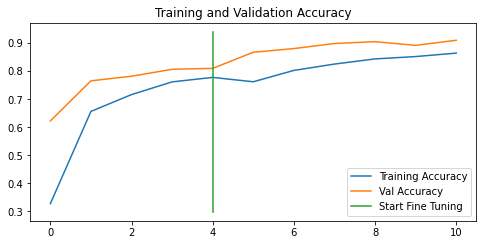

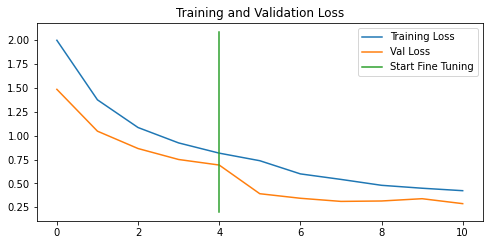

In [ ]:
 # How did fine-tuning go with more data?
 compare_histories(original_history=history_10_percent_data_aug,
                   new_history=history_fine_10_classes_full,
                   initial_epochs=5)

## Viewing our experiment data on tensorboard

> **Note:** Anything you upolad to TensorBoard.dev is going to be public, so if you have private data, do not upload it.

In [ ]:
# View tensorboard logs of transfer learning modeling experiments (should ~4 models)


!tensorboard dev upload --logdir ./transfer_learning \
  --name 'Transfer Learning Experiments with 10 Food101 classes' \
  --description 'A Series of different transfer learning experiments with varying amounts of data and fine-tuning' \
  --one_shot # exits the uploader once its finished uploading

2021-10-16 01:23:57.545686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-16 01:23:57.554949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-16 01:23:57.555563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Priv

My TensorBoard experiments are available at this link - https://tensorboard.dev/experiment/AGLnNEkzQaaSKgAiMZNVqg/

In [ ]:
# view all of your tensorboard experiments
!tensorboard dev list

2021-10-16 01:33:11.275213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-16 01:33:11.284189: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-16 01:33:11.284921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
https://tensorboard.dev/experiment/AGLnNEkzQaaSKgAiMZNVqg/
	Name                 Transfer Learning Experiments with 10 Food101 classes
	Description          A Series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   AGLnNEkzQaaSKgAiMZNVqg
	Created              2021-10-16 01:24:27

In [ ]:
# To delete an experiment
# !tensorboard dev delete -- experiment_id AGLnNEkzQaaSKgAiMZNVqg